# Améliorez le produit IA de votre start-up

In [49]:
import warnings
warnings.simplefilter(action='ignore')

### basic libs

import os
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
import operator

# api

from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

# text 

from nltk.stem.snowball import EnglishStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# image

import tensorflow as tf
from sklearn.manifold import TSNE

pyLDAvis.enable_notebook()

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

debug = 1


### API queries

In [50]:
with open("api.key", "r") as f:
    api_key = f.readline()


header = {'Authorization': f'bearer {api_key}',
         'Content-Type': 'application/json'}

# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(url="https://api.yelp.com/v3/graphql", headers=header, use_json=True)

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)


In [51]:
def get_new_reviews(city):

    df_reviews = pd.DataFrame(columns=['text', 'rating'])
    
    offset = 50
    
    for chunk in range(4):
        query = '''
        {
          search(term:"restaurants",
                 limit : 50,
                 offset: '''+str(offset*chunk)+''',
                 location:"''' + city + '''") {
            business {
              reviews {
                text
                rating
              }
            }
          }
        }
        '''
        query = gql(query)
        result = client.execute(query)
    
        for business in result["search"]["business"]:
            for review in business["reviews"]:
                df_reviews = df_reviews.append(review, ignore_index=True)
                
    df_reviews = df_reviews.dropna()

    df_reviews.to_csv('new_reviews.csv')
    
    print(f"Got {df_reviews.shape[0]} reviews")
    
    print(df_reviews.head())
    
# get_new_reviews("san francisco")

### Comments analysis

In [52]:
if debug:
    nrows = 1000
else:
    nrows = None

filename = './preprocessed_reviews.csv'

comments = pd.read_csv(filename, nrows=nrows)

comments.head()

,tokenized_text
0,marriott renaiss marriott huge desk atrium sta...
1,cool chill bunch neanderth bouncer hop steroid...
2,set perfect adequ dine chain chili victoria st...
3,correct crappi inconsist gone hill steadili 9
4,bolt follow fanni fabric fanni select fabric l...


In [53]:
def plot_hist_stats(df, feature, title=None, verticale=False):
    """Affiche l'histogramme d'une caractéristique"""
    tmp = df[feature].value_counts()
    df_tmp = pd.DataFrame({ 
                            feature: tmp.index,
                            'Quantity': tmp.values
                          })

    fig, ax = plt.subplots(figsize=(15,6))
    sns.set_color_codes("pastel")

    s = sns.barplot(ax = ax,
                    x = feature,
                    y = 'Quantity',
                    data = df_tmp)
   
    if title != None:
        plt.title(title)

    if verticale == True:
        plt.xticks(rotation=90)

    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();
    
def plot_coherence_values(df_coherence):
        """
        plot c_v coherence for various number of topics
        """
        fig, ax = plt.subplots(figsize=(12,6))
        sns.set_color_codes("pastel")
    
        s = sns.lineplot(ax = ax, x = 'nb_of_topics', y = 'coherence_value', data = df_coherence)
        plt.title('Coherence score evolution with number of topics')
        plt.show()
        
def dist_plot_nb_characters_and_words():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    sns.set_style('darkgrid')

    list_nb_characters = [len(x) for x in comments["tokenized_text"]]
    list_nb_of_words = [len(x.split()) for x in comments["tokenized_text"]]

    ax1.set_title('number of characters per clean review distribution')
    sns.histplot(list_nb_characters, ax = ax1)

    ax2.set_title('number of words per clean review distribution')
    sns.histplot(list_nb_of_words, ax = ax2)

    plt.show()

def plot_freqDist():
    ## Creating FreqDist,keeping the 30 most common tokens
    fdist_sw = FreqDist(list_list_to_list(comments["tokenized_text"].to_list())).most_common(30)

    df_fdist_sw = pd.Series(dict(fdist_sw))

    sns.barplot(x=df_fdist_sw.values, y=df_fdist_sw.index, ax=ax1)
    plt.set_title('Most commons words in tokenized text')

    plt.show()

In [54]:
models_best_coherence_score = {}

comments["tokenized_text"] = comments["tokenized_text"].apply(lambda x: x.split())

def list_list_to_list(x):
    return [item for sublist in x for item in sublist]

def clean_data_rdy(data_ready_for_model):
    dictionary = gensim.corpora.Dictionary(data_ready_for_model)
    count = 0

    for k, v in dictionary.iteritems():
        count += 1
        if count > 10:
            break

    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary

    
def LDA_TF_IDF(start, limit):
    # Create Dictionary
    id2word = clean_data_rdy(comments["tokenized_text"])

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments["tokenized_text"]]

    tfidf = gensim.models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    coherence = []
    for k in list(range(start, limit, 1)):         
        ldamodel_tf_idf = gensim.models.LdaMulticore(corpus_tfidf,
                                                     num_topics=k,
                                                     id2word = id2word,
                                                     iterations=200,
                                                     passes=2,
                                                     workers=4)

        cm = gensim.models.coherencemodel.CoherenceModel(model = ldamodel_tf_idf, 
                                                         texts = comments["tokenized_text"],
                                                         dictionary = id2word,
                                                         coherence='c_v')

        coherence.append((k,cm.get_coherence()))

    #Create dataframe with coherence value for each number of topic
    df_coherence = pd.DataFrame(coherence, columns=['nb_of_topics', 'coherence_value'])

    #Select best number of topic
    best_num_topic = df_coherence['nb_of_topics'][df_coherence['coherence_value'].idxmax()]
    models_best_coherence_score['LDA_TF_IDF'] = df_coherence['coherence_value'].max()

    #Plot
    plot_coherence_values(df_coherence)

    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                                 num_topics=best_num_topic,
                                                 id2word=id2word,
                                                 iterations=200,
                                                 passes=2,
                                                 workers=4)
    #visualization
    visualisation = gensimvis.prepare(lda_model_tfidf, corpus, id2word)

    return lda_model_tfidf, visualisation
    
        
def LDA(start, limit):
    """
    Compute c_v coherence for various number of topics
    """        
    # Create Dictionary
    id2word = clean_data_rdy(comments["tokenized_text"])

    # Create Corpus: Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in comments["tokenized_text"]]

    coherence = []
    for k in list(range(start, limit, 1)):
        Lda = gensim.models.ldamodel.LdaModel

        ldamodel = Lda( corpus,
                        num_topics=k,
                        id2word = id2word,
                        iterations=200)

        cm = gensim.models.coherencemodel.CoherenceModel(model = ldamodel, 
                                                         texts = comments["tokenized_text"],
                                                         dictionary = id2word,
                                                         coherence='c_v')

        coherence.append((k,cm.get_coherence()))

    #Create dataframe with coherence value for each number of topic
    df_coherence = pd.DataFrame(coherence, columns=['nb_of_topics', 'coherence_value'])

    #Select best number of topic
    best_num_topic = df_coherence['nb_of_topics'][df_coherence['coherence_value'].idxmax()]
    models_best_coherence_score['LDA'] = df_coherence['coherence_value'].max()

    #Plot
    plot_coherence_values(df_coherence)


    #Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                                id2word = id2word,
                                                num_topics = best_num_topic,
                                                iterations=200)

    #visualization
    visualisation = gensimvis.prepare(lda_model, corpus, id2word)

    return lda_model, visualisation


In [55]:
def lda_coherency():

    LDA_model, lda_visu = LDA(4,11)

    for idx, topic in LDA_model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
    return LDA_model, lda_visu
        
# LDA_model, lda_visu = lda_coherency()

In [56]:
# lda_visu

In [57]:
def tf_idf_lda_coherency():
    TF_IDF_LDA_model, lda_tf_idf_visu = LDA_TF_IDF(4, 11)

    for idx, topic in TF_IDF_LDA_model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
    return TF_IDF_LDA_model, lda_tf_idf_visu
        
# TF_IDF_LDA_model, lda_tf_idf_visu = tf_idf_lda_coherency()

In [58]:
# lda_tf_idf_visu

### Picture analysis

In [59]:
nrows = 131072

n_epochs = 20

test_nrows = 2048

val_nrows = 2048

batch_size = 16

steps_per_epoch = nrows // (batch_size * 1)

AUTOTUNE = tf.data.AUTOTUNE

In [60]:
test_size = 2048

val_size = 2048

BUFFER_SIZE = 1000

lbls = ['interior', 'outside', 'menu', 'food', 'drink']

def get_path(name):
    return os.path.join("preprocessed_imgs", f"{name}.jpg")

def train_test_img_split():
    pictures = pd.read_json("photos.json", lines=True)[["photo_id", "label"]]
    pictures["path"] = pictures["photo_id"].apply(get_path)
    pictures = pictures[["path", "label"]]
    pictures = pictures.sample(frac=1) # shuffle
    pictures["label"] = pictures["label"].apply(lambda x:  {'interior': 0, 'outside': 1, 'menu': 2, 'food': 3, 'drink': 4}[x])
    test_df = pictures.head(test_size)
    pictures = pictures.tail(pictures.shape[0] - test_size)
    val_df = pictures.head(val_size)
    pictures = pictures.tail(pictures.shape[0] - val_size)
    test_df.to_csv('photos_test.csv', index=False)
    val_df.to_csv('photos_val.csv', index=False)
    pictures.to_csv('photos_train.csv', index=False)
    
def load_img(path, tgt):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    tgt = tf.reshape(tgt, [1])
    return img, tgt

def set_shapes(image, label):
    image.set_shape((224, 224, 3))
    return image, label

# train_test_img_split()

In [61]:
train_df = pd.read_csv('photos_train.csv')
train_df = train_df.sample(frac=1)
train_df = train_df.head(nrows)
test_df = pd.read_csv('photos_test.csv')
test_df = test_df.head(test_nrows)
val_df = pd.read_csv('photos_val.csv')
val_df = val_df.head(val_nrows)


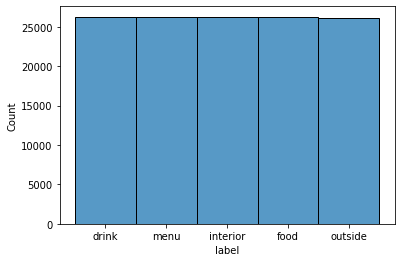

,path,label
124733,preprocessed_imgs\6-0wIVH5PtfkqRgYcUaluQ.jpg,4
120612,preprocessed_imgs\Q4YKbXP_MeduImp2-GXaYg.jpg,2
40903,preprocessed_imgs\9iry4GJp2cpMX_HEeVrdEg.jpg,2
142442,preprocessed_imgs\jYvMCa75Xb1Uix9BHVU8cA.jpg,2
33648,preprocessed_imgs\JK-6KKQfm1U5tU523OIyXg.jpg,2


In [62]:
test_df = test_df[["path", "label"]]
sns.histplot(x=train_df["label"].apply(lambda x: lbls[x]))
plt.show()
train_df.head()

In [63]:
cmap = cm.get_cmap('tab20')

def display_learning_curves(hst):
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
def tsne(mdl, lr=200.0, pp=40):
    target = [*map(lambda x:int(x[0]), list(np.concatenate([y for x, y in test_ds], axis=0)))]
    model_2 = tf.keras.models.Sequential(mdl.layers[:-1])
    res = model_2.predict(test_ds)
    tsne = TSNE(n_components=2, verbose=1, perplexity=pp, n_iter=2000, learning_rate=lr)
    tsne_results = tsne.fit_transform(res)
    fig, ax = plt.subplots(figsize=(8,8))
    for lab in range(5):
        indices = [tg == lab for tg in target]
        ax.scatter(tsne_results[indices, 0],
                   tsne_results[indices, 1],
                   c=np.array(cmap(lab)).reshape(1, 4),
                   label=lbls[lab],
                   alpha=0.5)
    ax.legend(fontsize='large', markerscale=2)
    plt.title('TSNE Scatter Plot')
    plt.show()

In [64]:
# make tf dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df["path"].values, tf.cast(train_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_df["path"].values, tf.cast(test_df["label"].values, tf.int32)))
val_ds = tf.data.Dataset.from_tensor_slices((val_df["path"].values, tf.cast(val_df["label"].values, tf.int32))).shuffle(BUFFER_SIZE)
# load imgs from path
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_img, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_img, num_parallel_calls=AUTOTUNE)
# set imgs shape
train_ds = train_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
# preprocess datasets
train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#### Création d'un CNN

In [65]:
has_trained = 1

if has_trained:
    cnn = tf.keras.models.load_model('custom_cnn')
    cnn_history = pd.read_csv('cnn_history.csv')
else:
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    cnn.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(5, activation='softmax'))

print(cnn.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0

In [66]:
def train_cnn():
    cnn.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6), metrics=["accuracy"])
    hist = cnn.fit(train_ds, batch_size=batch_size, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, verbose=2)
    hist_df = pd.DataFrame(data=hist.history)
    hist_df.to_csv('cnn_history.csv', index=False)
    cnn.save('custom_cnn')
    
    return hist_df

# cnn_history = train_cnn()

In [67]:
def cnn_stats():
    cnn_performance = cnn.evaluate(test_ds)
    display_learning_curves(cnn_history)
    cnn_pred = cnn.predict(test_ds)
    test_df["cnn_label"] = [np.argmax(x) for x in cnn_pred]


#### Fine-tuning partiel de VGG16

In [68]:
has_trained = 1

layer_freeze = 17

if has_trained:
    vgg_16_finetuned = tf.keras.models.load_model('vgg16_finetuned')
    vgg_16_finetuned_history = pd.read_csv('vgg_16_finetuned_history.csv')
else:
    vgg_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = vgg_model.output
    x = tf.keras.layers.Flatten()(x)
    predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
    vgg_16_finetuned = tf.keras.Model(inputs=vgg_model.input, outputs=predictions) 
    for layer in vgg_16_finetuned.layers[:layer_freeze]:
        layer.trainable = False
    for layer in vgg_16_finetuned.layers[layer_freeze:]:
        layer.trainable = True
        
print(vgg_16_finetuned.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [69]:
def train_vgg_16_finetuned():
    vgg_16_finetuned.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    hist = vgg_16_finetuned.fit(train_ds, batch_size=batch_size, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, verbose=2)
    hist_df = pd.DataFrame(data=hist.history)
    hist_df.to_csv('vgg_16_finetuned_history.csv', index=False)
    vgg_16_finetuned.save('vgg16_finetuned')
    
    return hist_df

# vgg_16_finetuned_history = train_vgg_16_finetuned()

In [70]:
def vgg_16_finetuned_stats():
    performance = vgg_16_finetuned.evaluate(test_ds)
    display_learning_curves(vgg_16_finetuned_history)
    model_pred = vgg_16_finetuned.predict(test_ds)
    test_df["vgg16_finetuned_label"] = [np.argmax(x) for x in model_pred]
    

#### Fine-tuning total de VGG16

In [71]:
has_trained = 1

layer_freeze = 0 

if has_trained:
    vgg_16_fully_finetuned = tf.keras.models.load_model('vgg_16_fully_finetuned')
    vgg_16_fully_finetuned_history = pd.read_csv('vgg_16_fully_finetuned_history.csv')
else:
    vgg_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = vgg_model.output
    x = tf.keras.layers.Flatten()(x)
    predictions = tf.keras.layers.Dense(5, activation='softmax')(x)
    vgg_16_fully_finetuned = tf.keras.Model(inputs=vgg_model.input, outputs=predictions) 
    for layer in vgg_16_fully_finetuned.layers[:layer_freeze]:
        layer.trainable = False
    for layer in vgg_16_fully_finetuned.layers[layer_freeze:]:
        layer.trainable = True
        
print(vgg_16_fully_finetuned.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [72]:
def train_vgg_16_fully_finetuned():
    vgg_16_fully_finetuned.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])
    hist = vgg_16_fully_finetuned.fit(train_ds, batch_size=batch_size, epochs=n_epochs, steps_per_epoch=steps_per_epoch, validation_data=val_ds, verbose=2)
    hist_df = pd.DataFrame(data=hist.history)
    hist_df.to_csv('vgg_16_fully_finetuned_history.csv', index=False)
    vgg_16_fully_finetuned.save('vgg_16_fully_finetuned')
    
    return hist_df

# vgg_16_fully_finetuned_history = train_vgg_16_fully_finetuned()

In [73]:
def vgg_16_fully_finetuned_stats():
    performance = vgg_16_fully_finetuned.evaluate(test_ds)
    display_learning_curves(vgg_16_fully_finetuned_history)
    model_pred = vgg_16_fully_finetuned.predict(test_ds)
    test_df["vgg_16_fully_finetuned_label"] = [np.argmax(x) for x in model_pred]
    # test_df.to_csv('photos_test.csv', index=False)


### Résulats

#### Custom CNN

128/128 [==============================] - 2s 19ms/step - loss: 0.7229 - accuracy: 0.7861


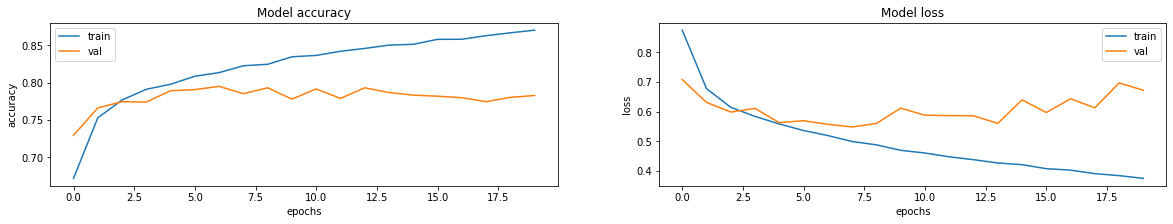

In [74]:
cnn_stats()

#### Fine-tuning partiel de VGG16

128/128 [==============================] - 11s 85ms/step - loss: 0.3306 - accuracy: 0.8848


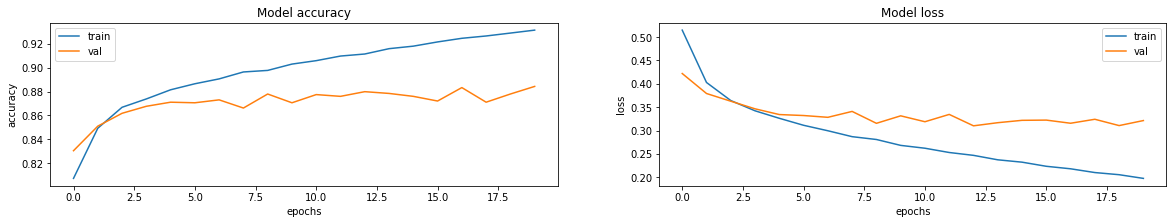

In [75]:
vgg_16_finetuned_stats()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2048 samples in 0.042s...
[t-SNE] Computed neighbors for 2048 samples in 2.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2048
[t-SNE] Computed conditional probabilities for sample 2000 / 2048
[t-SNE] Computed conditional probabilities for sample 2048 / 2048
[t-SNE] Mean sigma: 11.079870
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.433777
[t-SNE] KL divergence after 2000 iterations: 2.168388


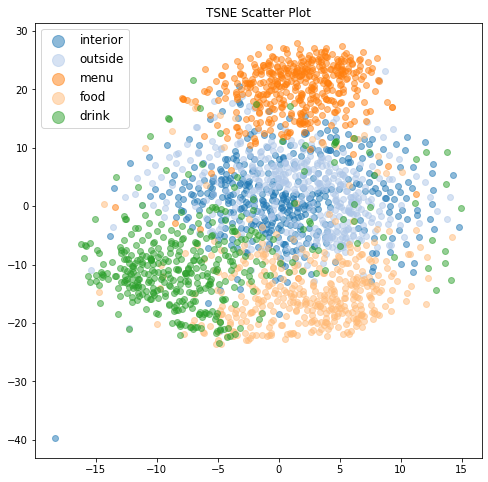

In [76]:
tsne(vgg_16_finetuned)

#### Fine-tuning total de VGG16

In [ ]:
vgg_16_fully_finetuned_stats()

128/128 [==============================] - 11s 85ms/step - loss: 0.2543 - accuracy: 0.9204


[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 2048 samples in 0.042s...
[t-SNE] Computed neighbors for 2048 samples in 2.830s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2048
[t-SNE] Computed conditional probabilities for sample 2000 / 2048
[t-SNE] Computed conditional probabilities for sample 2048 / 2048
[t-SNE] Mean sigma: 22.825989
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.092724
[t-SNE] KL divergence after 2000 iterations: 1.110333


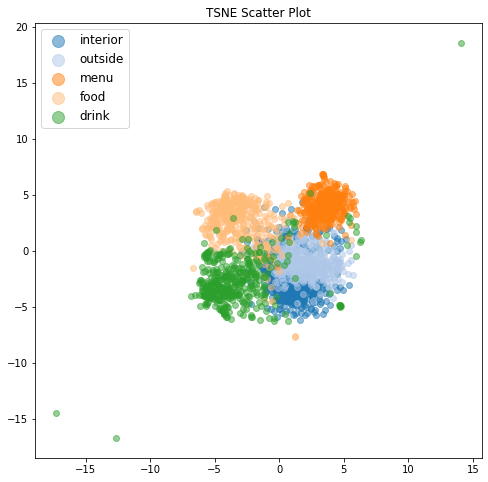

In [48]:
tsne(vgg_16_fully_finetuned, pp=200, lr=2)

#### Visualisation individuelle

In [29]:
label_cols = ["label", "cnn_label", "vgg16_finetuned_label", "vgg_16_fully_finetuned_label"]
for cl in label_cols:
    test_df[cl] = test_df[cl].apply(lambda x: lbls[x])
test_df.head(20)

,path,label,cnn_label,vgg16_finetuned_label,vgg_16_fully_finetuned_label
0,preprocessed_imgs\B3ZuApY7y3d9ChncFftGWg.jpg,outside,outside,interior,interior
1,preprocessed_imgs\JzB39WuBOXzUlvPaT8T5Eg.jpg,outside,outside,outside,outside
2,preprocessed_imgs\GRexps6TfrorhkSKAdGGTA.jpg,food,food,food,food
3,preprocessed_imgs\vKl3sdJ8ZyIHBCTwoQWmeQ.jpg,food,food,food,food
4,preprocessed_imgs\8TFfGVJg0W5sXuGjaYGm3w.jpg,outside,outside,outside,outside
5,preprocessed_imgs\vJtlOmqg21zhkacoVbf7Ig.jpg,food,food,food,food
6,preprocessed_imgs\RFkAe8h4IuQjf6RnYFgNJQ.jpg,drink,interior,interior,interior
7,preprocessed_imgs\J_PfnJmUkWuAvdehSV0jSw.jpg,interior,interior,interior,interior
8,preprocessed_imgs\mr9qiZxgZ0p26iT4602JMw.jpg,menu,menu,menu,menu
9,preprocessed_imgs\xgZuoJ6uAG_dx4BDlvsnCg.jpg,interior,interior,interior,interior


In [37]:
def show_img(name):
    img = mpimg.imread(f'./yelp_photos/{name}.jpg')
    imgplot = plt.imshow(img)
    plt.show()

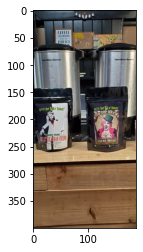

In [38]:
# drink	interior	interior	interior
show_img("RFkAe8h4IuQjf6RnYFgNJQ")

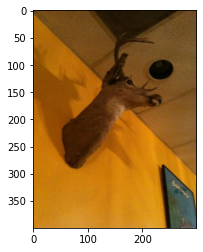

In [39]:
# interior	drink	drink	food
show_img("Uoby69h0Nd2kPs5dLYZGsQ")

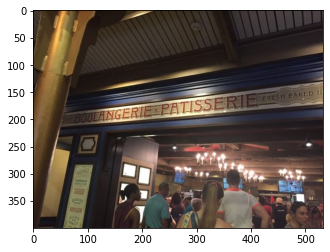

In [40]:
# outside	outside	interior	interior
show_img("B3ZuApY7y3d9ChncFftGWg")